# Analysis of Employee Absenteeism

The project is addressed 'Absenteeism' at a company during work time.

*Absenteeism is absence from work during normal working hours, resulting in temporary incapacity to execute regular working activity.

*_Motivation behind this project is that application of my learnings in the area of Data Science._*

## _Install dependecies_

In [ ]:
!pip install -r requirements.txt

## Importing Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score

%matplotlib inline
sns.set()

### Reading data and Exploring data 


In [2]:
raw_data = pd.read_csv("data/Absenteeism-data.csv")

In [3]:
raw_data.drop("ID",axis=1, inplace=True)

In [4]:
raw_data.describe(include="all")

,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
count,700.000000,700,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
unique,NaN,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,17/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19.411429,NaN,222.347143,29.892857,36.417143,271.801774,26.737143,1.282857,1.021429,0.687143,6.761429
std,8.356292,NaN,66.312960,14.804446,6.379083,40.021804,4.254701,0.668090,1.112215,1.166095,12.670082
min,0.000000,NaN,118.000000,5.000000,27.000000,205.917000,19.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,NaN,179.000000,16.000000,31.000000,241.476000,24.000000,1.000000,0.000000,0.000000,2.000000
50%,23.000000,NaN,225.000000,26.000000,37.000000,264.249000,25.000000,1.000000,1.000000,0.000000,3.000000
75%,27.000000,NaN,260.000000,50.000000,40.000000,294.217000,31.000000,1.000000,2.000000,1.000000,8.000000


In [5]:
data_with_dummies = raw_data.copy()
reasons = pd.get_dummies(data_with_dummies["Reason for Absence"],drop_first=True)

In [6]:
data_with_dummies.describe(include="all")

,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
count,700.000000,700,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
unique,NaN,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,17/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19.411429,NaN,222.347143,29.892857,36.417143,271.801774,26.737143,1.282857,1.021429,0.687143,6.761429
std,8.356292,NaN,66.312960,14.804446,6.379083,40.021804,4.254701,0.668090,1.112215,1.166095,12.670082
min,0.000000,NaN,118.000000,5.000000,27.000000,205.917000,19.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,NaN,179.000000,16.000000,31.000000,241.476000,24.000000,1.000000,0.000000,0.000000,2.000000
50%,23.000000,NaN,225.000000,26.000000,37.000000,264.249000,25.000000,1.000000,1.000000,0.000000,3.000000
75%,27.000000,NaN,260.000000,50.000000,40.000000,294.217000,31.000000,1.000000,2.000000,1.000000,8.000000


The age distribution is shown as between 27-30 and between 35-40 have higher percentage in the histogram.

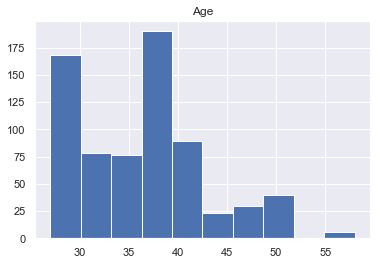

In [7]:
data_with_dummies.hist(column=["Age"]);

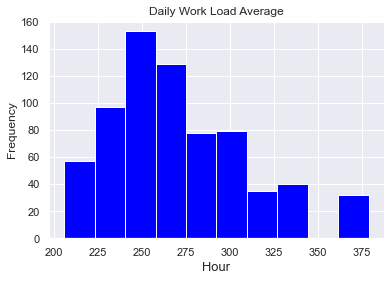

In [8]:
data_with_dummies["Daily Work Load Average"].plot(kind='hist', color='blue')
plt.title("Daily Work Load Average")
plt.xlabel('Hour', fontsize=13);

## Reason for absence:
28 different reasons for absence from work. Checking for labels for classifications


In [9]:
reasons.head()


,1,2,3,4,5,6,7,8,9,10,...,18,19,21,22,23,24,25,26,27,28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In the plot we can see that 7 absenteeism time in hours has the highest percentage and also the highest distance to work. Distance is an important factor for absenteeism.

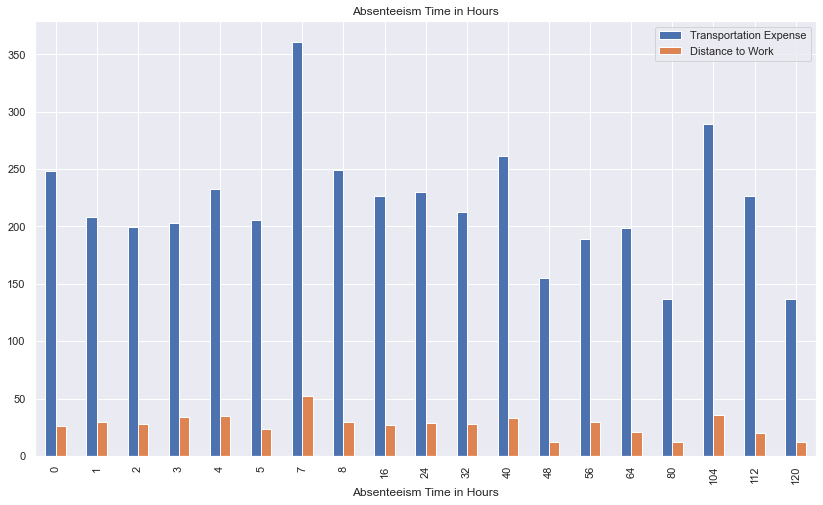

In [10]:

data_with_dummies[['Transportation Expense', 'Distance to Work','Absenteeism Time in Hours']].groupby(['Absenteeism Time in Hours']).mean().plot(kind='bar', figsize=(14, 8), title='Absenteeism Time in Hours');

In [11]:
data_with_dummies[data_with_dummies.Age < 40].select_dtypes(include = ['float64', 'int64']).groupby('Age').agg(['count', 'mean']).transpose()

Age                                      27          28          29  \
Reason for Absence        count    7.000000  113.000000    7.000000   
                          mean    18.285714   19.433628   18.571429   
Transportation Expense    count    7.000000  113.000000    7.000000   
                          mean   184.000000  266.345133  157.000000   
Distance to Work          count    7.000000  113.000000    7.000000   
                          mean    42.000000   29.646018   27.000000   
Daily Work Load Average   count    7.000000  113.000000    7.000000   
                          mean   301.190143  275.706558  263.365857   
Body Mass Index           count    7.000000  113.000000    7.000000   
                          mean    21.000000   24.725664   22.000000   
Education                 count    7.000000  113.000000    7.000000   
                          mean     1.000000    1.141593    1.000000   
Children                  count    7.000000  113.000000    7.000000   
                          mean     0.000000    0.858407    0.000000   
Pets                      count    7.000000  113.000000    7.000000   
                          mean     0.000000    2.106195    0.000000   
Absenteeism Time in Hours count    7.000000  113.000000    7.000000   
                          mean     3.857143    5.539823    4.428571   

Age                                      30          31          32  \
Reason for Absence        count   41.000000   17.000000   13.000000   
                          mean    19.439024   16.058824   16.076923   
Transportation Expense    count   41.000000   17.000000   13.000000   
                          mean   179.000000  345.000000  247.923077   
Distance to Work          count   41.000000   17.000000   13.000000   
                          mean    26.000000   23.000000   23.846154   
Daily Work Load Average   count   41.000000   17.000000   13.000000   
                          mean   266.053171  262.849059  260.889385   
Body Mass Index           count   41.000000   17.000000   13.000000   
                          mean    19.000000   24.294118   24.538462   
Education                 count   41.000000   17.000000   13.000000   
                          mean     3.000000    1.176471    2.538462   
Children                  count   41.000000   17.000000   13.000000   
                          mean     0.000000    2.647059    0.000000   
Pets                      count   41.000000   17.000000   13.000000   
                          mean     0.000000    1.411765    0.000000   
Absenteeism Time in Hours count   41.000000   17.000000   13.000000   
                          mean     5.878049    6.823529    3.692308   

Age                                      33          34          36  \
Reason for Absence        count   48.000000   27.000000   49.000000   
                          mean    18.687500   19.407407   19.265306   
Transportation Expense    count   48.000000   27.000000   49.000000   
                          mean   273.541667  155.000000  276.857143   
Distance to Work          count   48.000000   27.000000   49.000000   
                          mean    33.937500   12.000000   49.857143   
Daily Work Load Average   count   48.000000   27.000000   49.000000   
                          mean   271.306271  303.924630  272.560347   
Body Mass Index           count   48.000000   27.000000   49.000000   
                          mean    29.062500   25.000000   22.714286   
Education                 count   48.000000   27.000000   49.000000   
                          mean     1.041667    1.000000    1.000000   
Children                  count   48.000000   27.000000   49.000000   
                          mean     1.916667    2.000000    3.714286   
Pets                      count   48.000000   27.000000   49.000000   
                          mean     1.104167    0.000000    0.571429   
Absenteeism Time in Hours count   48.000000   27.000000   49.000000   
                      

### We can drop the values and assign as label vector

In [12]:
data_with_dummies = data_with_dummies.drop("Reason for Absence", axis =1)

### Group the Reasons for Absence:
    - Manuel classifying the same reasons into group in order to decrease dimensionality of the data
    - Classification is based on real reasons which is mentioned above

In [13]:
reason_type1 = reasons.loc[:,"1":"14"].max(axis=1)
reason_type2 = reasons.loc[:, "15":"17"].max(axis=1)
reason_type3 = reasons.loc[:, "18":"21"].max(axis=1)
reason_type4 = reasons.loc[:, "22":].max(axis=1)

## Concatenate the Column Values
After grouping the reasons which are similar, we can reconstruct dataframe from them. Having said that we can compare the labels with our feature before we train our model

In [14]:
data_with_dummies = pd.concat([data_with_dummies,reason_type1, reason_type2, reason_type3,reason_type4], axis=1)

In [15]:
data_with_dummies

,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,0,1,2,3
0,07/07/2015,289,36,33,239.554,30,1,2,1,4,0,0,0,1
1,14/07/2015,118,13,50,239.554,31,1,1,0,0,0,0,0,0
2,15/07/2015,179,51,38,239.554,31,1,0,0,2,0,0,0,1
3,16/07/2015,279,5,39,239.554,24,1,2,0,4,1,0,0,0
4,23/07/2015,289,36,33,239.554,30,1,2,1,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,23/05/2018,179,22,40,237.656,22,2,2,0,8,1,0,0,0
696,23/05/2018,225,26,28,237.656,24,1,1,2,3,1,0,0,0
697,24/05/2018,330,16,28,237.656,25,2,0,0,8,1,0,0,0
698,24/05/2018,235,16,32,237.656,25,3,0,0,2,0,0,0,1


In [16]:
data_with_dummies.columns.values

array(['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 0, 1, 2, 3],
      dtype=object)

#### We can rename our columns for reasons type

In [17]:
column_names = ['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', "reason_type1", "reason_type2", "reason_type3", "reason_type4"]


In [18]:
data_with_dummies.columns= column_names

In [19]:
data_with_dummies.columns.values

array(['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'reason_type1',
       'reason_type2', 'reason_type3', 'reason_type4'], dtype=object)

## Finalizing the columns
 - Reordering the columns for legibility
 - Data types of each columns should correctly mapped. For example, for date columns data type should be DatetimeIndex
 

In [20]:
columns = ['reason_type1',
       'reason_type2', 'reason_type3', 'reason_type4','Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours' ]

In [21]:
data_with_dummies = data_with_dummies[columns]

In [22]:
data_with_dummies.columns.values

array(['reason_type1', 'reason_type2', 'reason_type3', 'reason_type4',
       'Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours'], dtype=object)

In [23]:
type(data_with_dummies["Date"][0])

str

In [24]:
data_mod = data_with_dummies.copy()

In [25]:
data_mod["Date"] = pd.to_datetime(data_mod["Date"], format="%d/%m/%Y")

In [26]:
data_mod

,reason_type1,reason_type2,reason_type3,reason_type4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,2015-07-07,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,2015-07-14,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,2015-07-15,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,2015-07-16,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,2015-07-23,289,36,33,239.554,30,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,2018-05-23,179,22,40,237.656,22,2,2,0,8
696,1,0,0,0,2018-05-23,225,26,28,237.656,24,1,1,2,3
697,1,0,0,0,2018-05-24,330,16,28,237.656,25,2,0,0,8
698,0,0,0,1,2018-05-24,235,16,32,237.656,25,3,0,0,2


In [27]:
type(data_mod["Date"][0])

pandas._libs.tslibs.timestamps.Timestamp

## Check for class balance
It can be seen that the data have equal classes for the label. For the model that is used in this data analysis, data should be balanced. Here, it is shown that there are four reasons so we have four labels for feature dataset.

In [28]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 14 columns):
reason_type1                 700 non-null uint8
reason_type2                 700 non-null uint8
reason_type3                 700 non-null uint8
reason_type4                 700 non-null uint8
Date                         700 non-null datetime64[ns]
Transportation Expense       700 non-null int64
Distance to Work             700 non-null int64
Age                          700 non-null int64
Daily Work Load Average      700 non-null float64
Body Mass Index              700 non-null int64
Education                    700 non-null int64
Children                     700 non-null int64
Pets                         700 non-null int64
Absenteeism Time in Hours    700 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(8), uint8(4)
memory usage: 57.5 KB


### Checking and correcting the data types of columns

In [29]:
months = []

for i in range(data_mod.shape[0]):
    months.append(data_mod["Date"][i].month)

In [36]:
len(months)

700

In [37]:
len(months)

700

In [38]:
data_mod["months"] = months

In [39]:
data_mod.head()

,reason_type1,reason_type2,reason_type3,reason_type4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,months
0,0,0,0,1,2015-07-07,289,36,33,239.554,30,1,2,1,4,7
1,0,0,0,0,2015-07-14,118,13,50,239.554,31,1,1,0,0,7
2,0,0,0,1,2015-07-15,179,51,38,239.554,31,1,0,0,2,7
3,1,0,0,0,2015-07-16,279,5,39,239.554,24,1,2,0,4,7
4,0,0,0,1,2015-07-23,289,36,33,239.554,30,1,2,1,2,7


In [40]:
data_mod["Date"][699].weekday()

3

In [41]:
def date_to_weekday(date_value):
    return date_value.weekday()

In [42]:
data_mod["Day of the Week"] = data_mod["Date"].apply(date_to_weekday)

In [43]:
data_mod

,reason_type1,reason_type2,reason_type3,reason_type4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,months,Day of the Week
0,0,0,0,1,2015-07-07,289,36,33,239.554,30,1,2,1,4,7,1
1,0,0,0,0,2015-07-14,118,13,50,239.554,31,1,1,0,0,7,1
2,0,0,0,1,2015-07-15,179,51,38,239.554,31,1,0,0,2,7,2
3,1,0,0,0,2015-07-16,279,5,39,239.554,24,1,2,0,4,7,3
4,0,0,0,1,2015-07-23,289,36,33,239.554,30,1,2,1,2,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,2018-05-23,179,22,40,237.656,22,2,2,0,8,5,2
696,1,0,0,0,2018-05-23,225,26,28,237.656,24,1,1,2,3,5,2
697,1,0,0,0,2018-05-24,330,16,28,237.656,25,2,0,0,8,5,3
698,0,0,0,1,2018-05-24,235,16,32,237.656,25,3,0,0,2,5,3


In [44]:
data_mod = data_mod.drop("Date", axis=1)

In [45]:
data_mod

,reason_type1,reason_type2,reason_type3,reason_type4,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,months,Day of the Week
0,0,0,0,1,289,36,33,239.554,30,1,2,1,4,7,1
1,0,0,0,0,118,13,50,239.554,31,1,1,0,0,7,1
2,0,0,0,1,179,51,38,239.554,31,1,0,0,2,7,2
3,1,0,0,0,279,5,39,239.554,24,1,2,0,4,7,3
4,0,0,0,1,289,36,33,239.554,30,1,2,1,2,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,179,22,40,237.656,22,2,2,0,8,5,2
696,1,0,0,0,225,26,28,237.656,24,1,1,2,3,5,2
697,1,0,0,0,330,16,28,237.656,25,2,0,0,8,5,3
698,0,0,0,1,235,16,32,237.656,25,3,0,0,2,5,3


In [46]:
data_mod.columns.values

array(['reason_type1', 'reason_type2', 'reason_type3', 'reason_type4',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'months',
       'Day of the Week'], dtype=object)

In [47]:
new_cols = ['reason_type1', 'reason_type2', 'reason_type3', 'reason_type4', 'months',
       'Day of the Week',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours']
data_final = data_mod[new_cols]

In [48]:
data_final.head(40)

,reason_type1,reason_type2,reason_type3,reason_type4,months,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,1,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,1,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,1,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,1,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,1,2,1,2
5,0,0,0,1,7,4,179,51,38,239.554,31,1,0,0,2
6,0,0,0,1,7,4,361,52,28,239.554,27,1,1,4,8
7,0,0,0,1,7,4,260,50,36,239.554,23,1,4,0,4
8,0,0,1,0,7,0,155,12,34,239.554,25,1,2,0,40
9,0,0,0,1,7,0,235,11,37,239.554,29,3,1,1,8


In [49]:
data_final["Daily Work Load Average"].unique()

array([239.554, 205.917, 241.476, 253.465, 306.345, 261.306, 308.593,
       302.585, 343.253, 326.452, 378.884, 377.55 , 275.312, 265.615,
       294.217, 265.017, 284.031, 236.629, 330.061, 251.818, 244.387,
       239.409, 246.074, 253.957, 230.29 , 249.797, 261.756, 284.853,
       268.519, 280.549, 313.532, 264.249, 222.196, 246.288, 237.656])

For Education column; 1: High school, 2: Graduate, 3: Post Graduate, 4: Master or PhD

In [50]:
data_final["Education"] = data_final["Education"].map({1:0,2:1,3:1,4:1})

In [51]:
data_final["Education"].value_counts()

0    583
1    117
Name: Education, dtype: int64

In [52]:
## Exploratory Data Analysis

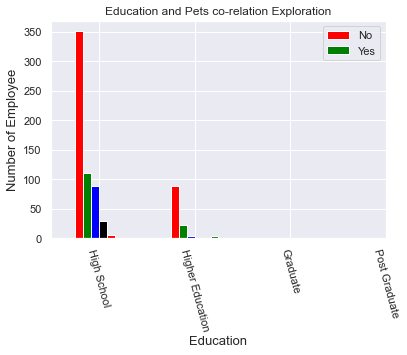

In [53]:
# visualization of Education and pets
pd.crosstab(data_final.Education, data_final.Pets).plot(kind = 'bar', color = ['red', 'green', 'blue', 'black'], title = 'Education and Pets co-relation Exploration')
plt.xlabel('Education', fontsize = 13)
plt.ylabel('Number of Employee', fontsize = 13)
plt.xticks([0, 1, 2, 3], ['High School', 'Higher Education', "Graduate", 'Post Graduate' ], rotation = -75)
plt.legend(['No', 'Yes']);

### Highly correlated variables
Pets ~ Distance to work

Pets ~ Children

Age ~ Children

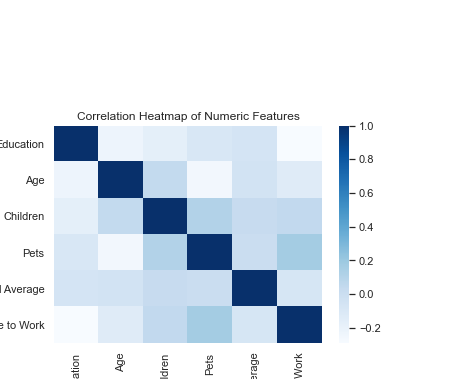

In [54]:
train_numerical = data_final[["Education", "Age", "Children","Pets",
                         "Daily Work Load Average", "Distance to Work"]]
corr = train_numerical.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Blues')
plt.title('Correlation Heatmap of Numeric Features');

The pairplot plot a pairwise relationships in our dataset. The pairplot function creates a grid of Axes such that each variable in our data will by shared in the y-axis across a single row and in the x-axis across a single column. 

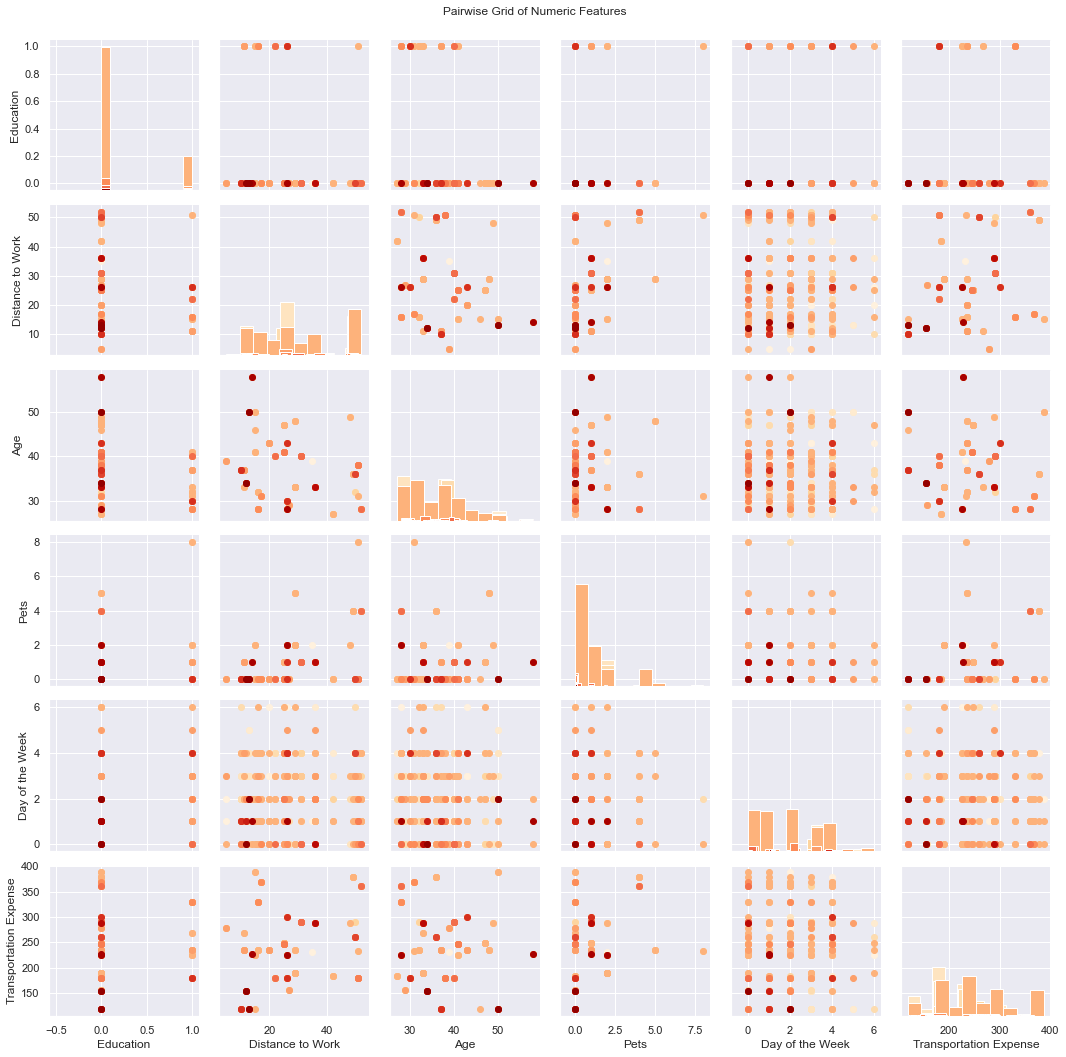

In [55]:
# Pair grid of key variables.
g = sns.PairGrid(data_final, vars=["Education", "Distance to Work", "Age","Pets", 
                           "Day of the Week", "Transportation Expense"], 
                 palette='OrRd', hue='Absenteeism Time in Hours')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Pairwise Grid of Numeric Features');

## Final Checkpoint

In [56]:
data_final.head()

,reason_type1,reason_type2,reason_type3,reason_type4,months,Day of the Week,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,0,0,0,1,7,1,289,36,33,239.554,30,0,2,1,4
1,0,0,0,0,7,1,118,13,50,239.554,31,0,1,0,0
2,0,0,0,1,7,2,179,51,38,239.554,31,0,0,0,2
3,1,0,0,0,7,3,279,5,39,239.554,24,0,2,0,4
4,0,0,0,1,7,3,289,36,33,239.554,30,0,2,1,2


## Targets
There is the pandas method called median which can help us in this section.The median value of the absenteeism time is 3.0 , in the cells everything below the median would be considered as normal. Everything above the median would be excessive.

In [57]:
targets = np.where(data_final["Absenteeism Time in Hours"] > data_final["Absenteeism Time in Hours"].median(),1,0)

In [58]:
data_final["Excessive Absenteeism"] = targets

## Comment on Targets
Using the median as a cutoff line is numerically stable and rigid. That's because by using the median we have implicitly balance the dataset roughly half of the targets are 0s while the other half 1s. This will prevent our model from learning to output one of the two classes exclusively. Total number of targets is simply the shape on axis zero.The result is around 0.46. So around 46 percent of the targets are 1s thus around 54 percent of the targets are 0s. Usually 60 40 split will work equally well for a logistic regression.

In [59]:
targets.sum() / targets.shape[0]

0.45571428571428574

In [60]:
data_with_targets = data_final.drop(["Absenteeism Time in Hours","Day of the Week", "Daily Work Load Average", "Distance to Work"], axis=1)

In [61]:
data_with_targets.head()

,reason_type1,reason_type2,reason_type3,reason_type4,months,Transportation Expense,Age,Body Mass Index,Education,Children,Pets,Excessive Absenteeism
0,0,0,0,1,7,289,33,30,0,2,1,1
1,0,0,0,0,7,118,50,31,0,1,0,0
2,0,0,0,1,7,179,38,31,0,0,0,0
3,1,0,0,0,7,279,39,24,0,2,0,1
4,0,0,0,1,7,289,33,30,0,2,1,0


## Inputs for the Regression

In [62]:
data_with_targets.shape

(700, 12)

In [63]:
data_with_targets.iloc[:,:-1]

,reason_type1,reason_type2,reason_type3,reason_type4,months,Transportation Expense,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,7,289,33,30,0,2,1
1,0,0,0,0,7,118,50,31,0,1,0
2,0,0,0,1,7,179,38,31,0,0,0
3,1,0,0,0,7,279,39,24,0,2,0
4,0,0,0,1,7,289,33,30,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,5,179,40,22,1,2,0
696,1,0,0,0,5,225,28,24,0,1,2
697,1,0,0,0,5,330,28,25,1,0,0
698,0,0,0,1,5,235,32,25,1,0,0


## Standardize the Data
There are several ways to perform standardization. Here the relevant module is imported from sklearn. It will subtract the mean and divide by the standard deviation from each point variable wise.

In [64]:
unscaled_inputs = data_with_targets.iloc[:,:-1]

In [65]:
targets_data = data_with_targets.iloc[:,-1]

In [66]:
unscaled_inputs

,reason_type1,reason_type2,reason_type3,reason_type4,months,Transportation Expense,Age,Body Mass Index,Education,Children,Pets
0,0,0,0,1,7,289,33,30,0,2,1
1,0,0,0,0,7,118,50,31,0,1,0
2,0,0,0,1,7,179,38,31,0,0,0
3,1,0,0,0,7,279,39,24,0,2,0
4,0,0,0,1,7,289,33,30,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
695,1,0,0,0,5,179,40,22,1,2,0
696,1,0,0,0,5,225,28,24,0,1,2
697,1,0,0,0,5,330,28,25,1,0,0
698,0,0,0,1,5,235,32,25,1,0,0


In [67]:
from sklearn.preprocessing import StandardScaler

In [ ]:
absenteeism_scaler = StandardScaler()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class CustomScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self,columns, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy,with_mean, with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns],y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.mean(X[self.columns])
        return self
    
    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled =pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:,~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [ ]:
unscaled_inputs.columns.values


In [ ]:
#columns_to_scale = ['months', 'Day of the Week', 'Transportation Expense',
 #      'Distance to Work', 'Age', 'Daily Work Load Average',
  #     'Body Mass Index', 'Education', 'Children', 'Pets'] 

In [ ]:
columns_to_omit = ['reason_type1', 'reason_type2', 'reason_type3', 'reason_type4','Education']

In [ ]:
columns_to_scale = [x for x in unscaled_inputs.columns.values if x not in columns_to_omit]

In [ ]:
absenteeism_scaler =CustomScaler(columns_to_scale)

In [ ]:
absenteeism_scaler.fit(unscaled_inputs)

In [ ]:
scaled_inputs = absenteeism_scaler.transform(unscaled_inputs)

In [ ]:
scaled_inputs

In [ ]:
scaled_inputs.shape

## Split the Data and into Train & Test and Shuffle
Sklearn has a pretty neat method of splitting the data into train and test in order to use it we must import it. The train size is selected as 0.8. This means that 80% of the data will be used for training and 20 % for testing.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs,targets_data,train_size=0.8, random_state=42)

## Logistic Regression with sklearn
For a machine learning model there are many mathematical issues arising in the background. Imperfect libraries such as statsmodel are not always numerically stable for more complicated models. That's why sklearn is used for this model.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [ ]:
y_train.shape

## Training the Model

In [ ]:
reg = LogisticRegression()

In [ ]:
reg.fit(x_train,y_train)

###### We conclude that our model has an accuracy of 80%. In other words based on the data we used our model learned to classify 80 percent of the observations correctly.

In [ ]:
reg.score(x_train,y_train)

## Manually Check the Accuracy
That's needed for two reasons. First, it is always good to have the full understanding of what we are doing and secondly, we will be using this idea later on.

In [ ]:
model_outputs = reg.predict(x_train)

In [ ]:
model_outputs == y_train

###### Train accuracy:

In [ ]:
np.sum(model_outputs == y_train) / model_outputs.shape[0]

## Intercept and Coefficients

In [ ]:
reg.intercept_


In [ ]:
reg.coef_

In [ ]:
feature_name = unscaled_inputs.columns.values

In [ ]:
unscaled_inputs.columns.values

## Summary Table

In [ ]:
summary_table = pd.DataFrame(data = feature_name, columns=["Feature Names"])

In [ ]:
summary_table["Coefficient"] = np.transpose(reg.coef_)

In [ ]:
summary_table

In [ ]:
summary_table.index = summary_table.index + 1

In [ ]:
summary_table.drop(1, axis=0)

In [ ]:
summary_table

In [ ]:
summary_table.loc[0] = ["intercepts", reg.intercept_[0]]
summary_table = summary_table.sort_index()

In [ ]:
summary_table

There are a coefficient values and standardized coefficient values. These standardized coefficients are basically the coefficient values of a regression where all variables have been standardized other packages in software include the standardized coefficients because they allow for a simple and easy to understand comparison between the variables since in such cases the features are standardized.

In [ ]:
summary_table["Odds_ratio"] = np.exp(summary_table.Coefficient)

If a coefficient is around zero or its odds ratio is close to 1, this means that the corresponding feature is not particularly important.

In [ ]:
summary_table.sort_values(by="Odds_ratio", ascending=False)

## Testing the Model

In [ ]:
reg.score(x_train,y_train)

In [ ]:
reg.score(x_test,y_test)

Test and train accuracy is equal and this  mean that our model overfitted and it learned the train data very well.

###### Divide data into train and test

In [ ]:
x_test.shape


In [ ]:
x_train.shape

In [ ]:
y_test.shape

In [ ]:
y_train.shape

The first column shows the probability of our model assigned to the observation being 0 and the second the probability the model assigned to the observation being 1.

In [ ]:
predict_proba =reg.predict_proba(x_test)
predict_proba

###### This give us the probabilities of excessive absenteeism.

In [ ]:
predict_proba[:,1]

### Exporting the results to pickle for archive 

In [ ]:
import pickle

In [ ]:
with open("model", "wb") as file:
    pickle.dump(reg,file)

In [ ]:
with open("absenteeism", "wb") as file:
    pickle.dump(absenteeism_scaler,file)

## Conclusion
This study has shown that analysis of absenteeism of employee. It depends on several factors. From the model, we noticed that children, pets, distance to work and transportation expenses have a significant effect on the absenteeism.

 ® Hasan Kaya 2020
 

*The Github repository can be found [here](https://github.com/mrhasankaya/Data-Analysis-Productivity)*